In [1]:
#importing all the necessary libraries 
import pandas as pd
import pandas_profiling as pp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import plotly.graph_objects as go
import plotly.io as pio
import pickle
from sklearn.utils import resample

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, auc, roc_curve

In [4]:
# Validation
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline, make_pipeline


In [5]:
# Tuning
from sklearn.model_selection import GridSearchCV


In [6]:
# Feature Extraction
from sklearn.feature_selection import RFE


In [7]:
# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, LabelEncoder

In [8]:
# Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


In [9]:
# Ensembles
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [10]:
sns.set_style("whitegrid", {'axes.grid' : False})
pio.templates.default = "plotly_white"


In [11]:
#analyzing data
def explore_data(df):
    print("Number of Instances and Attributes:", df.shape)
    print('\n')
    print('Dataset columns:',df.columns)
    print('\n')
    print('Data types of each columns: ', df.info())

In [12]:
#checking for duplicates
def checking_removing_duplicates(df):
    count_dups = df.duplicated().sum()
    print("Number of Duplicates: ", count_dups)
    if count_dups >= 1:
        df.drop_duplicates(inplace=True)
        print('Duplicate values removed!')
    else:
        print('No Duplicate values')

In [13]:
#Splitting data to training and validation datasets 
def read_in_and_split_data(data, target):
    X = data.drop(target, axis=1)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test

In [14]:
#Spot checking the algorithms 
def GetModel():
    Models = []
    Models.append(('LR'   , LogisticRegression()))
    Models.append(('LDA'  , LinearDiscriminantAnalysis()))
    Models.append(('KNN'  , KNeighborsClassifier()))
    Models.append(('CART' , DecisionTreeClassifier()))
    Models.append(('NB'   , GaussianNB()))
    Models.append(('SVM'  , SVC(probability=True)))
    return Models

In [15]:
#Spot-Checking normalised models
def ensemblemodels():
    ensembles = []
    ensembles.append(('AB'   , AdaBoostClassifier()))
    ensembles.append(('GBM'  , GradientBoostingClassifier()))
    ensembles.append(('RF'   , RandomForestClassifier()))
    ensembles.append(( 'Bagging' , BaggingClassifier()))
    ensembles.append(('ET', ExtraTreesClassifier()))
    return ensembles

In [16]:

def NormalizedModel(nameOfScaler):
    
    if nameOfScaler == 'standard':
        scaler = StandardScaler()
    elif nameOfScaler =='minmax':
        scaler = MinMaxScaler()
    elif nameOfScaler == 'normalizer':
        scaler = Normalizer()
    elif nameOfScaler == 'binarizer':
        scaler = Binarizer()

    pipelines = []
    pipelines.append((nameOfScaler+'LR'  , Pipeline([('Scaler', scaler),('LR'  , LogisticRegression())])))
    pipelines.append((nameOfScaler+'LDA' , Pipeline([('Scaler', scaler),('LDA' , LinearDiscriminantAnalysis())])))
    pipelines.append((nameOfScaler+'KNN' , Pipeline([('Scaler', scaler),('KNN' , KNeighborsClassifier())])))
    pipelines.append((nameOfScaler+'CART', Pipeline([('Scaler', scaler),('CART', DecisionTreeClassifier())])))
    pipelines.append((nameOfScaler+'NB'  , Pipeline([('Scaler', scaler),('NB'  , GaussianNB())])))
    pipelines.append((nameOfScaler+'SVM' , Pipeline([('Scaler', scaler),('SVM' , SVC())])))
    pipelines.append((nameOfScaler+'AB'  , Pipeline([('Scaler', scaler),('AB'  , AdaBoostClassifier())])  ))
    pipelines.append((nameOfScaler+'GBM' , Pipeline([('Scaler', scaler),('GMB' , GradientBoostingClassifier())])  ))
    pipelines.append((nameOfScaler+'RF'  , Pipeline([('Scaler', scaler),('RF'  , RandomForestClassifier())])  ))
    pipelines.append((nameOfScaler+'ET'  , Pipeline([('Scaler', scaler),('ET'  , ExtraTreesClassifier())])  ))

    return pipelines


In [17]:
#Training the model
def fit_model(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'accuracy'

    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=num_folds, shuffle=True, random_state=0)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return names, results

In [18]:
#Saving the model
def save_model(model,filename):
    pickle.dump(model, open(filename, 'wb'))

In [19]:
#Performance Measurement
def classification_metrics(model, conf_matrix):
    print(f"Training Accuracy Score: {model.score(X_train, y_train) * 100:.1f}%")
    print(f"Validation Accuracy Score: {model.score(X_test, y_test) * 100:.1f}%")
    fig,ax = plt.subplots(figsize=(8,6))
    sns.heatmap(pd.DataFrame(conf_matrix), annot = True, cmap = 'YlGnBu',fmt = 'g')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.title('Confusion Matrix', fontsize=20, y=1.1)
    plt.ylabel('Actual label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.show()
    print(classification_report(y_test, y_pred))

In [20]:
#Loading the dataset
df = pd.read_csv('/content/drive/MyDrive/Voting Dataset - Sheet1.csv')


In [21]:
#Removing Outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [22]:
#Splitting Data to Training and Validation set
target ='Chances of Getting Into the Council'
X_train, X_test, y_train, y_test = read_in_and_split_data(df, target)


Training Accuracy Score: 28.1%
Validation Accuracy Score: 19.5%


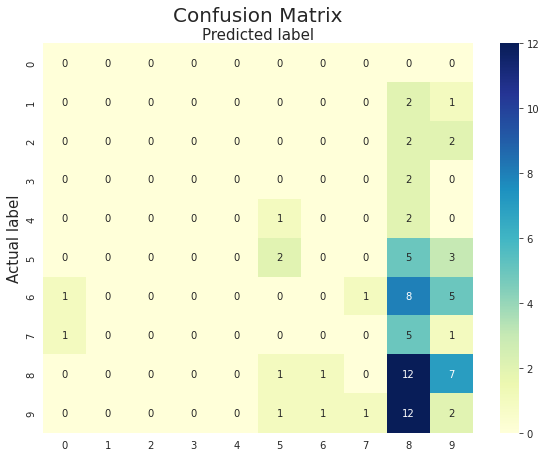

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         3
           6       0.40      0.20      0.27        10
           7       0.00      0.00      0.00        15
           8       0.00      0.00      0.00         7
           9       0.24      0.57      0.34        21
          10       0.10      0.12      0.11        17

    accuracy                           0.20        82
   macro avg       0.07      0.09      0.07        82
weighted avg       0.13      0.20      0.14        82



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [23]:
#Train model
pipeline = make_pipeline(StandardScaler(),  GaussianNB())
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test,y_pred)
classification_metrics(pipeline, conf_matrix)

In [24]:
#save model
save_model(model, 'model1.pkl')